In [2]:
import pandas as pd
import yfinance as yf
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import json
import torch
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
from keras import regularizers
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, mean_squared_log_error
import matplotlib.pyplot as plt
import numpy as np
import itertools
import statsmodels.api as sm
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from scikeras.wrappers import KerasRegressor
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay


In [3]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
# Load the file
stock_name = "CSCO"
file_path = f"stock_datasets/{stock_name}.xlsx"
if file_path.endswith('.csv'):
    news_df = pd.read_csv(file_path)
elif file_path.endswith('.xlsx'):
    news_df = pd.read_excel(file_path)
else:
    raise ValueError("Unsupported file format. Please provide a CSV or XLSX file.")

# Remove rows where the 'Time' column has invalid dates
news_df['Time'] = pd.to_datetime(news_df['Time'], errors='coerce')  # Convert invalid dates to NaT
news_df = news_df.dropna(subset=['Time'])  # Drop rows with NaT in 'Time'

# Display the cleaned DataFrame
print(news_df)

                                         absolute href  \
0    https://www.investing.com/news/pro/key-takeawa...   
1    https://www.investing.com/news/pro/cisco-sys-i...   
2    https://www.investing.com/news/swot-analysis/c...   
3    https://www.investing.com/news/insider-trading...   
4    https://www.investing.com/news/insider-trading...   
..                                                 ...   
995  https://www.investing.com/news/stock-market-ne...   
996  https://www.investing.com/news/technology-news...   
997  https://www.investing.com/news/stock-market-ne...   
998  https://www.investing.com/news/stock-market-ne...   
999  https://www.investing.com/news/stock-market-ne...   

                                                     z  \
0    https://i-invdn-com.investing.com/news/WallStr...   
1    https://i-invdn-com.investing.com/news/Cisco-S...   
2    https://i-invdn-com.investing.com/news/LYNXNPE...   
3    https://i-invdn-com.investing.com/news/CiscoSy...   
4    https://

In [4]:
# Sort the DataFrame by 'Time'
news_df_sorted = news_df.sort_values(by='Time')

# Remove duplicate rows and select only 'Title' and 'Time' columns
news_df_cleaned = news_df_sorted[['Title', 'Time']].drop_duplicates()

# Rename the 'Time' column to 'Date'
news_df_cleaned = news_df_cleaned.rename(columns={'Time': 'Date'})

# Optionally, reset the index after removing duplicates
news_df_cleaned = news_df_cleaned.reset_index(drop=True)

# Save the cleaned data as JSON
news_df_cleaned.to_json(f"news_title/{stock_name}_news_title.json", orient='records', lines=True)

# Display the cleaned DataFrame
news_df_cleaned.head()


,Title,Date
0,"Stocks - Cisco, Exxon Fall in Premarket; Rolls...",2020-02-28
1,Cisco Stock Falls 4%,2020-03-05
2,Cisco Stock Rises 4%,2020-03-10
3,"White House, tech industry meet to discuss cor...",2020-03-11
4,Cisco Stock Rises 7%,2020-03-13


In [5]:
# Determine the start and end dates from the news data
start_date = news_df_cleaned['Date'].min().strftime('%Y-%m-%d')
end_date = news_df_cleaned['Date'].max().strftime('%Y-%m-%d')

# Download historical data for AstraZeneca (AZN) based on the date range from the news data
stock_data = yf.download(stock_name, start=start_date, end=end_date)

# Display the first few rows of the data
print(stock_data.head())
print(stock_data.tail())

[*********************100%%**********************]  1 of 1 completed

                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2020-02-28  38.700001  40.549999  38.349998  39.930000  34.419785  80188000
2020-03-02  40.150002  41.189999  38.919998  41.169998  35.488678  48864300
2020-03-03  41.259998  41.900002  39.709999  40.040001  34.514610  49294700
2020-03-04  40.720001  41.450001  39.799999  41.389999  35.678314  30022100
2020-03-05  40.169998  40.509998  39.290001  39.570000  34.109467  30255900
                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2024-12-13  58.619999  58.939999  58.380001  58.619999  58.619999  14129700
2024-12-16  58.470001  58.490002  57.849998  58.349998  58.349998  26883200
2024-12-17  58.380001  59.070000  58.169998  58.520000  58.520000  24912500
2024-12-18  58.709999  58.709999  57.480000  57.529999  57.529999  24195100
2024-12-19  

In [6]:
modelName = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(modelName)
model = AutoModelForSequenceClassification.from_pretrained(modelName)
def calculateDailySentiment(headlines):
    texts = [headline['heading'] for headline in headlines]
    inputs = tokenizer(texts, return_tensors="pt", truncation=True, padding=True, max_length=512, return_attention_mask=True)
    outputs = model(**inputs)
    logits = outputs.logits
    scores = logits.softmax(dim=1)
    averageScore = scores.mean(dim=0).tolist()
    return averageScore


def analyzeAndSaveSentiment(inputFile, outputFile):
    result = {}
    
    # Open the file and process each line as a separate JSON object
    with open(inputFile, 'r',  encoding="utf8") as file:
        for line in file:
            # Parse each line (record) as a separate JSON object
            record = json.loads(line)
            date = record.get('Date')
            title = record.get('Title')

            if date and title:
                # Convert the timestamp to a readable date
                readable_date = datetime.fromtimestamp(int(date) / 1000).strftime('%Y-%m-%d')
                
                # Prepare the headlines in the required format
                headlines = [{'heading': title}]
                averageScore = calculateDailySentiment(headlines)
                print(f"{readable_date} > {averageScore}")
                result[readable_date] = averageScore


    with open(outputFile, 'w', encoding="utf8") as outFile:
        json.dump(result, outFile, indent=2)


In [7]:
inputJsonFile = f"news_title/{stock_name}_news_title.json"
outputJsonFile = f"sentiment_score/{stock_name}_news_sentiment_score.json"

analyzeAndSaveSentiment(inputJsonFile, outputJsonFile)

2020-02-28 > [0.3940788209438324, 0.3327779769897461, 0.19339288771152496, 0.05247120559215546, 0.027279136702418327]
2020-03-05 > [0.4148557484149933, 0.3044804036617279, 0.19759565591812134, 0.056893084198236465, 0.026175079867243767]
2020-03-10 > [0.2596174478530884, 0.21735058724880219, 0.20260486006736755, 0.1647164672613144, 0.15571068227291107]
2020-03-11 > [0.12209714204072952, 0.10803241282701492, 0.17358316481113434, 0.2967241406440735, 0.2995631992816925]
2020-03-13 > [0.262592613697052, 0.21349532902240753, 0.20765595138072968, 0.1504165530204773, 0.16583965718746185]
2020-03-17 > [0.2596174478530884, 0.21735058724880219, 0.20260486006736755, 0.1647164672613144, 0.15571068227291107]
2020-03-18 > [0.3160979151725769, 0.41709959506988525, 0.21759997308254242, 0.0341762900352478, 0.015026277862489223]
2020-03-18 > [0.2414821833372116, 0.20942379534244537, 0.20136456191539764, 0.15944954752922058, 0.188279926776886]
2020-03-19 > [0.2733213007450104, 0.17295707762241364, 0.10245

2020-07-09 > [0.305753618478775, 0.4048577547073364, 0.23163896799087524, 0.042430829256772995, 0.015318798832595348]
2020-07-10 > [0.2458709180355072, 0.37002241611480713, 0.2765713036060333, 0.06740473955869675, 0.040130615234375]
2020-07-13 > [0.0855117067694664, 0.030828585848212242, 0.05868162587285042, 0.13725805282592773, 0.687720000743866]
2020-07-16 > [0.3755430281162262, 0.2770913243293762, 0.24462735652923584, 0.07857919484376907, 0.024159109219908714]
2020-07-17 > [0.2701370418071747, 0.4150424599647522, 0.25608953833580017, 0.04461135342717171, 0.014119580388069153]
2020-07-20 > [0.4321528375148773, 0.21038784086704254, 0.19096639752388, 0.091305673122406, 0.07518719136714935]
2020-07-21 > [0.08734149485826492, 0.07312742620706558, 0.10423680394887924, 0.2714591920375824, 0.4638350307941437]
2020-07-22 > [0.07507367432117462, 0.056662581861019135, 0.10714724659919739, 0.3198363482952118, 0.4412801265716553]
2020-07-23 > [0.3968234360218048, 0.17005077004432678, 0.124595880

2020-12-23 > [0.39376887679100037, 0.16798672080039978, 0.1777472048997879, 0.14466048777103424, 0.11583676934242249]
2020-12-24 > [0.6836668252944946, 0.17086325585842133, 0.09182628244161606, 0.0332225002348423, 0.020421136170625687]
2021-01-02 > [0.6836668252944946, 0.17086325585842133, 0.09182628244161606, 0.0332225002348423, 0.020421136170625687]
2021-01-08 > [0.44171133637428284, 0.17743819952011108, 0.15436653792858124, 0.11084369570016861, 0.11564027518033981]
2021-01-11 > [0.2736142575740814, 0.24336107075214386, 0.18142616748809814, 0.17015689611434937, 0.13144166767597198]
2021-01-19 > [0.44103655219078064, 0.18656256794929504, 0.1562642753124237, 0.10782682150602341, 0.10830987244844437]
2021-01-19 > [0.06160324439406395, 0.04404710233211517, 0.1085340678691864, 0.2561735212802887, 0.5296420454978943]
2021-01-25 > [0.40060943365097046, 0.211085245013237, 0.17825086414813995, 0.11905939131975174, 0.0909949466586113]
2021-02-05 > [0.02726535126566887, 0.012421260587871075, 0.

2021-08-19 > [0.3670962452888489, 0.356454998254776, 0.20760107040405273, 0.05099165812134743, 0.017855996266007423]
2021-08-19 > [0.39388880133628845, 0.3562346398830414, 0.19019947946071625, 0.040382858365774155, 0.019294166937470436]
2021-08-19 > [0.20582082867622375, 0.3131006062030792, 0.26125842332839966, 0.13926856219768524, 0.08055159449577332]
2021-08-19 > [0.025389820337295532, 0.030541211366653442, 0.08978889882564545, 0.31923264265060425, 0.5350474119186401]
2021-08-19 > [0.27191075682640076, 0.4129602611064911, 0.2566419839859009, 0.044520601630210876, 0.01396639458835125]
2021-08-20 > [0.27828699350357056, 0.36944565176963806, 0.2576135993003845, 0.05985603854060173, 0.03479763865470886]
2021-08-20 > [0.07031501829624176, 0.053441908210515976, 0.12322727590799332, 0.29174375534057617, 0.46127212047576904]
2021-08-20 > [0.020435797050595284, 0.022607384249567986, 0.10340432822704315, 0.3151830732822418, 0.5383694767951965]
2021-08-23 > [0.1922769993543625, 0.21339254081249

2022-01-18 > [0.31803324818611145, 0.42060884833335876, 0.21432949602603912, 0.03285492584109306, 0.014173397794365883]
2022-01-19 > [0.3170945942401886, 0.47292113304138184, 0.19333647191524506, 0.013878260739147663, 0.0027695666067302227]
2022-02-08 > [0.029338601976633072, 0.0197967030107975, 0.0566503182053566, 0.1464751809835434, 0.7477391958236694]
2022-02-11 > [0.45970964431762695, 0.17573079466819763, 0.13017600774765015, 0.10213325917720795, 0.13225027918815613]
2022-02-13 > [0.11891335994005203, 0.09408202022314072, 0.18348407745361328, 0.3127140998840332, 0.29080650210380554]
2022-02-13 > [0.0017483467236161232, 0.001323629985563457, 0.0035810149274766445, 0.03575119748711586, 0.9575957655906677]
2022-02-14 > [0.11891335994005203, 0.09408202022314072, 0.18348407745361328, 0.3127140998840332, 0.29080650210380554]
2022-02-14 > [0.4304468631744385, 0.26669320464134216, 0.15481847524642944, 0.07838118076324463, 0.06966018676757812]
2022-02-14 > [0.5130858421325684, 0.17923097312

2022-06-23 > [0.719428300857544, 0.15189111232757568, 0.07500392198562622, 0.02945670858025551, 0.02422000840306282]
2022-06-28 > [0.7618265151977539, 0.12935468554496765, 0.041041724383831024, 0.023645589128136635, 0.04413139075040817]
2022-06-28 > [0.296313613653183, 0.15830105543136597, 0.18778061866760254, 0.18788881599903107, 0.16971591114997864]
2022-06-28 > [0.2860349118709564, 0.26616397500038147, 0.20748157799243927, 0.13119734823703766, 0.10912210494279861]
2022-07-06 > [0.27975860238075256, 0.367571085691452, 0.25968584418296814, 0.05948178470134735, 0.03350261598825455]
2022-07-08 > [0.7796889543533325, 0.11156602203845978, 0.055589668452739716, 0.02523353323340416, 0.027921725064516068]
2022-07-11 > [0.2523508369922638, 0.12297599762678146, 0.17510674893856049, 0.2073679268360138, 0.24219852685928345]
2022-07-12 > [0.6239497661590576, 0.19647860527038574, 0.0772300586104393, 0.0432615801692009, 0.059080012142658234]
2022-07-12 > [0.5112048387527466, 0.22804905474185944, 0.

2022-11-12 > [0.37384235858917236, 0.20171312987804413, 0.2214541733264923, 0.13626272976398468, 0.06672767549753189]
2022-11-13 > [0.17611761391162872, 0.10754063725471497, 0.1680595874786377, 0.280486136674881, 0.26779595017433167]
2022-11-13 > [0.426025927066803, 0.3590075671672821, 0.17321565747261047, 0.03143508732318878, 0.01031576283276081]
2022-11-14 > [0.2885962724685669, 0.20781874656677246, 0.17628513276576996, 0.16330496966838837, 0.1639949232339859]
2022-11-15 > [0.49953657388687134, 0.2529848515987396, 0.16932784020900726, 0.048760998994112015, 0.02938966080546379]
2022-11-16 > [0.2349722981452942, 0.27785956859588623, 0.2428608387708664, 0.13320110738277435, 0.11110621690750122]
2022-11-16 > [0.028830694034695625, 0.04685169458389282, 0.13022063672542572, 0.33907294273376465, 0.4550240635871887]
2022-11-16 > [0.008648548275232315, 0.00893242284655571, 0.034548070281744, 0.22094596922397614, 0.7269249558448792]
2022-11-16 > [0.31144362688064575, 0.3094751238822937, 0.2364

2023-02-20 > [0.32211580872535706, 0.16488522291183472, 0.21936650574207306, 0.16200891137123108, 0.13162364065647125]
2023-02-20 > [0.29554516077041626, 0.16235455870628357, 0.22787977755069733, 0.1792561262845993, 0.13496431708335876]
2023-02-20 > [0.7311570644378662, 0.14534568786621094, 0.06774205714464188, 0.028912045061588287, 0.026843026280403137]
2023-02-21 > [0.02491769939661026, 0.019871754571795464, 0.04567901790142059, 0.15673556923866272, 0.7527958750724792]
2023-02-21 > [0.32211580872535706, 0.16488522291183472, 0.21936650574207306, 0.16200891137123108, 0.13162364065647125]
2023-02-21 > [0.4354414939880371, 0.20209376513957977, 0.19519571959972382, 0.10729627311229706, 0.05997280031442642]
2023-02-27 > [0.03185679391026497, 0.038588471710681915, 0.13846264779567719, 0.35697466135025024, 0.4341174066066742]
2023-02-27 > [0.16877271234989166, 0.17780233919620514, 0.2300567775964737, 0.22019556164741516, 0.20317263901233673]
2023-03-07 > [0.29554516077041626, 0.1623545587062

2023-08-17 > [0.20496352016925812, 0.19629356265068054, 0.29652905464172363, 0.17754851281642914, 0.12466536462306976]
2023-08-18 > [0.05126527324318886, 0.049426376819610596, 0.1342388242483139, 0.25637516379356384, 0.5086944103240967]
2023-08-20 > [0.25457173585891724, 0.1669595092535019, 0.13884297013282776, 0.18639986217021942, 0.2532258927822113]
2023-08-21 > [0.274600088596344, 0.15057812631130219, 0.2249559611082077, 0.19484375417232513, 0.15502196550369263]
2023-08-21 > [0.04728001356124878, 0.08152124285697937, 0.1964692920446396, 0.32037270069122314, 0.3543567955493927]
2023-08-22 > [0.12732627987861633, 0.2347257137298584, 0.36374810338020325, 0.21466092765331268, 0.05953902751207352]
2023-08-28 > [0.33705875277519226, 0.1971282958984375, 0.16483937203884125, 0.13954150676727295, 0.16143213212490082]
2023-08-28 > [0.0215501356869936, 0.026979051530361176, 0.08353583514690399, 0.33392825722694397, 0.5340067148208618]
2023-08-31 > [0.019194575026631355, 0.02647508680820465, 0.

2024-01-09 > [0.3448275923728943, 0.13459201157093048, 0.12832266092300415, 0.14825338125228882, 0.24400432407855988]
2024-01-25 > [0.022189117968082428, 0.023964064195752144, 0.07102495431900024, 0.29357460141181946, 0.5892472863197327]
2024-02-06 > [0.014200970530509949, 0.019861336797475815, 0.076518215239048, 0.3440583348274231, 0.5453611016273499]
2024-02-06 > [0.035303715616464615, 0.04030490294098854, 0.09544844180345535, 0.322330117225647, 0.5066127777099609]
2024-02-06 > [0.11862099915742874, 0.0753319263458252, 0.13149088621139526, 0.2513434886932373, 0.4232127368450165]
2024-02-06 > [0.007063500117510557, 0.00964824017137289, 0.044134028255939484, 0.30749210715293884, 0.631662130355835]
2024-02-06 > [0.02442295290529728, 0.0271103847771883, 0.0919693261384964, 0.33668094873428345, 0.5198163390159607]
2024-02-07 > [0.01199105940759182, 0.014641870744526386, 0.06743074208498001, 0.34797924757003784, 0.557957112789154]
2024-02-08 > [0.274600088596344, 0.15057812631130219, 0.224

2024-04-03 > [0.4399735927581787, 0.19610708951950073, 0.173219695687294, 0.10951366275548935, 0.08118590712547302]
2024-04-04 > [0.01672849990427494, 0.022141437977552414, 0.09477513283491135, 0.36412128806114197, 0.502233624458313]
2024-04-04 > [0.06661013513803482, 0.058664269745349884, 0.11963558197021484, 0.30973947048187256, 0.4453504979610443]
2024-04-08 > [0.015044907107949257, 0.02052084170281887, 0.07807420194149017, 0.3349616527557373, 0.5513983964920044]
2024-04-09 > [0.274600088596344, 0.15057812631130219, 0.2249559611082077, 0.19484375417232513, 0.15502196550369263]
2024-04-09 > [0.5466341376304626, 0.26380157470703125, 0.11328553408384323, 0.04292238876223564, 0.033356331288814545]
2024-04-09 > [0.07388212531805038, 0.06564071029424667, 0.09563495218753815, 0.23791272938251495, 0.5269295573234558]
2024-04-09 > [0.002295616315677762, 0.0018163612112402916, 0.005418375600129366, 0.05694141983985901, 0.9335282444953918]
2024-04-10 > [0.09687573462724686, 0.072139210999012, 

2024-06-04 > [0.01283673383295536, 0.01905115693807602, 0.07085718959569931, 0.36711326241493225, 0.5301416516304016]
2024-06-04 > [0.01034197025001049, 0.012628591619431973, 0.04682478681206703, 0.28534024953842163, 0.6448643803596497]
2024-06-04 > [0.15647339820861816, 0.06955389678478241, 0.0926096960902214, 0.18249869346618652, 0.4988643229007721]
2024-06-04 > [0.01767878793179989, 0.020878231152892113, 0.06725793331861496, 0.32061854004859924, 0.5735664963722229]
2024-06-04 > [0.026030147448182106, 0.032660871744155884, 0.08628638088703156, 0.33403080701828003, 0.5209917426109314]
2024-06-05 > [0.274600088596344, 0.15057812631130219, 0.2249559611082077, 0.19484375417232513, 0.15502196550369263]
2024-06-05 > [0.27003204822540283, 0.2023562639951706, 0.20845147967338562, 0.1749257892370224, 0.14423440396785736]
2024-06-05 > [0.14981462061405182, 0.11852961033582687, 0.2368498593568802, 0.28295764327049255, 0.2118481695652008]
2024-06-05 > [0.027470478788018227, 0.034682244062423706,

2024-08-30 > [0.6953848004341125, 0.1461249589920044, 0.08807723224163055, 0.03629693388938904, 0.03411614149808884]
2024-09-10 > [0.01930137351155281, 0.02973148785531521, 0.14978303015232086, 0.44812309741973877, 0.3530609607696533]
2024-09-12 > [0.43694818019866943, 0.18156903982162476, 0.14072991907596588, 0.09360606968402863, 0.1471467912197113]
2024-09-12 > [0.564778208732605, 0.1820077747106552, 0.1246955394744873, 0.059493277221918106, 0.06902524083852768]
2024-09-12 > [0.4775196611881256, 0.18924175202846527, 0.13678792119026184, 0.08134957402944565, 0.11510109901428223]
2024-09-14 > [0.20388533174991608, 0.17057907581329346, 0.23848117887973785, 0.2027103304862976, 0.1843440681695938]
2024-09-16 > [0.004282534588128328, 0.005615168251097202, 0.0657946988940239, 0.4283806085586548, 0.4959269165992737]
2024-09-16 > [0.2636394202709198, 0.39709019660949707, 0.26211467385292053, 0.0568438284099102, 0.02031186781823635]
2024-09-24 > [0.02093193121254444, 0.028614820912480354, 0.11

2024-11-18 > [0.05906689167022705, 0.0520186573266983, 0.1167154535651207, 0.30161163210868835, 0.4705874025821686]
2024-11-18 > [0.04932740330696106, 0.04482796788215637, 0.11139082908630371, 0.30253177881240845, 0.4919220507144928]
2024-11-19 > [0.25699517130851746, 0.3548683226108551, 0.2809983789920807, 0.07609115540981293, 0.031047025695443153]
2024-11-19 > [0.033534660935401917, 0.04024575278162956, 0.09959085285663605, 0.35000157356262207, 0.4766272008419037]
2024-11-19 > [0.29314327239990234, 0.34832635521888733, 0.2517262101173401, 0.0772629901766777, 0.029541168361902237]
2024-11-19 > [0.38989540934562683, 0.1372424215078354, 0.14158523082733154, 0.12309522181749344, 0.208181694149971]
2024-11-19 > [0.40398484468460083, 0.14821664988994598, 0.14539247751235962, 0.12831079959869385, 0.17409516870975494]
2024-11-19 > [0.27841293811798096, 0.12332481890916824, 0.13417963683605194, 0.1706150621175766, 0.29346758127212524]
2024-11-21 > [0.3913936913013458, 0.14894519746303558, 0.1

In [8]:
# Load the sentiment scores from the JSON file
with open(f"sentiment_score/{stock_name}_news_sentiment_score.json", 'r') as f:
    sentiment_data = json.load(f)

# Create a DataFrame to store the sentiment scores without averaging them
processed_data = {
    'Date': [],
    'SentimentScores': []
}

# Iterate through the JSON data and append the sentiment scores for each date
for date, scores in sentiment_data.items():
    processed_data['Date'].append(date)
    processed_data['SentimentScores'].append(scores)  # Keep the list of sentiment scores

# Convert processed data to a DataFrame
news_sentiment_df = pd.DataFrame(processed_data)

# Ensure the 'Date' column is in datetime format
news_sentiment_df['Date'] = pd.to_datetime(news_sentiment_df['Date'])

# Display the DataFrame
news_sentiment_df


,Date,SentimentScores
0,2020-02-28,"[0.3940788209438324, 0.3327779769897461, 0.193..."
1,2020-03-05,"[0.4148557484149933, 0.3044804036617279, 0.197..."
2,2020-03-10,"[0.2596174478530884, 0.21735058724880219, 0.20..."
3,2020-03-11,"[0.12209714204072952, 0.10803241282701492, 0.1..."
4,2020-03-13,"[0.262592613697052, 0.21349532902240753, 0.207..."
...,...,...
488,2024-12-06,"[0.3354402482509613, 0.12905585765838623, 0.15..."
489,2024-12-11,"[0.04316829890012741, 0.037306319922208786, 0...."
490,2024-12-12,"[0.07141575962305069, 0.09987592697143555, 0.1..."
491,2024-12-17,"[0.274600088596344, 0.15057812631130219, 0.224..."


In [9]:
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-02-28,38.700001,40.549999,38.349998,39.930000,34.419785,80188000
2020-03-02,40.150002,41.189999,38.919998,41.169998,35.488678,48864300
2020-03-03,41.259998,41.900002,39.709999,40.040001,34.514610,49294700
2020-03-04,40.720001,41.450001,39.799999,41.389999,35.678314,30022100
2020-03-05,40.169998,40.509998,39.290001,39.570000,34.109467,30255900
...,...,...,...,...,...,...
2024-12-13,58.619999,58.939999,58.380001,58.619999,58.619999,14129700
2024-12-16,58.470001,58.490002,57.849998,58.349998,58.349998,26883200
2024-12-17,58.380001,59.070000,58.169998,58.520000,58.520000,24912500


In [10]:
news_sentiment_df.head()

,Date,SentimentScores
0,2020-02-28,"[0.3940788209438324, 0.3327779769897461, 0.193..."
1,2020-03-05,"[0.4148557484149933, 0.3044804036617279, 0.197..."
2,2020-03-10,"[0.2596174478530884, 0.21735058724880219, 0.20..."
3,2020-03-11,"[0.12209714204072952, 0.10803241282701492, 0.1..."
4,2020-03-13,"[0.262592613697052, 0.21349532902240753, 0.207..."


In [11]:
# Merge the two DataFrames on the 'Date' column
dfMerged = pd.merge(stock_data, news_sentiment_df, on='Date', how='left')

# Check if each element in 'SentimentScores' is a list, and replace invalid ones with NaN or an empty list
dfMerged['SentimentScores'] = dfMerged['SentimentScores'].apply(lambda x: x if isinstance(x, list) else [None] * 5)

# Ensure each list in 'SentimentScores' has 5 elements (or adjust this if your data varies)
dfMerged['SentimentScores'] = dfMerged['SentimentScores'].apply(lambda x: x if len(x) == 5 else [None] * 5)

# Convert the 'SentimentScores' list into separate columns
dfSentimentColumns = pd.DataFrame(dfMerged['SentimentScores'].tolist(), columns=['Very negative', 'Negative', 'Neutral', 'Positive', 'Very Positive'])

# Concatenate the origi|nal DataFrame with the new sentiment columns
dfMerged = pd.concat([dfMerged, dfSentimentColumns], axis=1)

# Drop unnecessary columns
dfMerged = dfMerged.drop(columns=['SentimentScores'])

# Display the merged DataFrame
dfMerged.head()


,Date,Open,High,Low,Close,Adj Close,Volume,Very negative,Negative,Neutral,Positive,Very Positive
0,2020-02-28,38.700001,40.549999,38.349998,39.930000,34.419785,80188000,0.394079,0.332778,0.193393,0.052471,0.027279
1,2020-03-02,40.150002,41.189999,38.919998,41.169998,35.488678,48864300,NaN,NaN,NaN,NaN,NaN
2,2020-03-03,41.259998,41.900002,39.709999,40.040001,34.514610,49294700,NaN,NaN,NaN,NaN,NaN
3,2020-03-04,40.720001,41.450001,39.799999,41.389999,35.678314,30022100,NaN,NaN,NaN,NaN,NaN
4,2020-03-05,40.169998,40.509998,39.290001,39.570000,34.109467,30255900,0.414856,0.304480,0.197596,0.056893,0.026175


In [12]:
dfMerged[['Very negative', 'Negative', 'Neutral', 'Positive', 'Very Positive']] = dfMerged[['Very negative', 'Negative', 'Neutral', 'Positive', 'Very Positive']].interpolate(method='linear', axis=0)
dfMerged

,Date,Open,High,Low,Close,Adj Close,Volume,Very negative,Negative,Neutral,Positive,Very Positive
0,2020-02-28,38.700001,40.549999,38.349998,39.930000,34.419785,80188000,0.394079,0.332778,0.193393,0.052471,0.027279
1,2020-03-02,40.150002,41.189999,38.919998,41.169998,35.488678,48864300,0.399273,0.325704,0.194444,0.053577,0.027003
2,2020-03-03,41.259998,41.900002,39.709999,40.040001,34.514610,49294700,0.404467,0.318629,0.195494,0.054682,0.026727
3,2020-03-04,40.720001,41.450001,39.799999,41.389999,35.678314,30022100,0.409662,0.311555,0.196545,0.055788,0.026451
4,2020-03-05,40.169998,40.509998,39.290001,39.570000,34.109467,30255900,0.414856,0.304480,0.197596,0.056893,0.026175
...,...,...,...,...,...,...,...,...,...,...,...,...
1207,2024-12-13,58.619999,58.939999,58.380001,58.619999,58.619999,14129700,0.139144,0.116777,0.201544,0.281309,0.261226
1208,2024-12-16,58.470001,58.490002,57.849998,58.349998,58.349998,26883200,0.206872,0.133677,0.213250,0.238076,0.208124
1209,2024-12-17,58.380001,59.070000,58.169998,58.520000,58.520000,24912500,0.274600,0.150578,0.224956,0.194844,0.155022
1210,2024-12-18,58.709999,58.709999,57.480000,57.529999,57.529999,24195100,0.274600,0.150578,0.224956,0.194844,0.155022


Missing values:
Date             0
Open             0
High             0
Low              0
Close            0
Adj Close        0
Volume           0
Very negative    0
Negative         0
Neutral          0
Positive         0
Very Positive    0
dtype: int64
Statistical summary:
              Open         High          Low        Close    Adj Close  \
count  1212.000000  1212.000000  1212.000000  1212.000000  1212.000000   
mean     49.269802    49.726485    48.834497    49.298977    45.989971   
std       5.495436     5.465654     5.532201     5.501356     5.966575   
min      33.230000    35.820000    32.400002    33.200001    28.618511   
25%      45.544999    45.930000    45.060001    45.557500    41.380508   
50%      49.030001    49.565001    48.594999    49.060001    46.841503   
75%      53.340000    53.672499    52.860001    53.259998    50.143132   
max      64.040001    64.290001    63.549999    63.959999    60.020000   

             Volume  Very negative     Negative      Ne

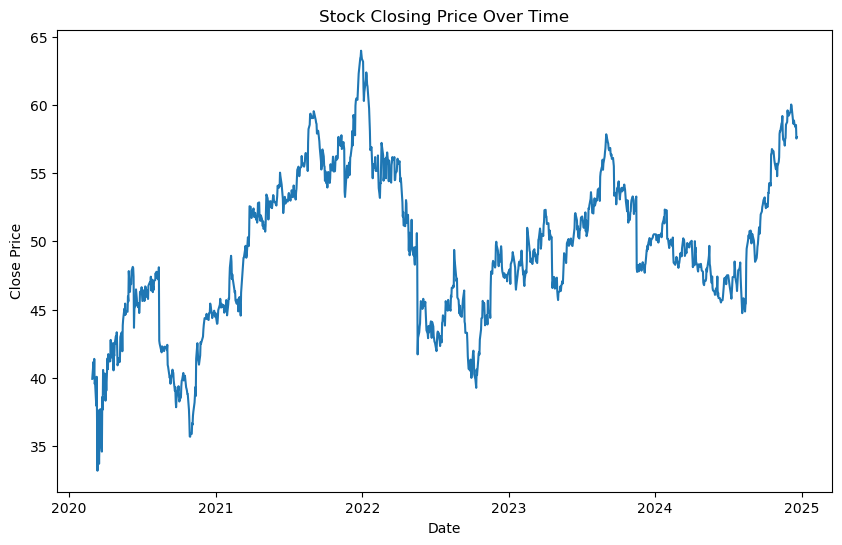

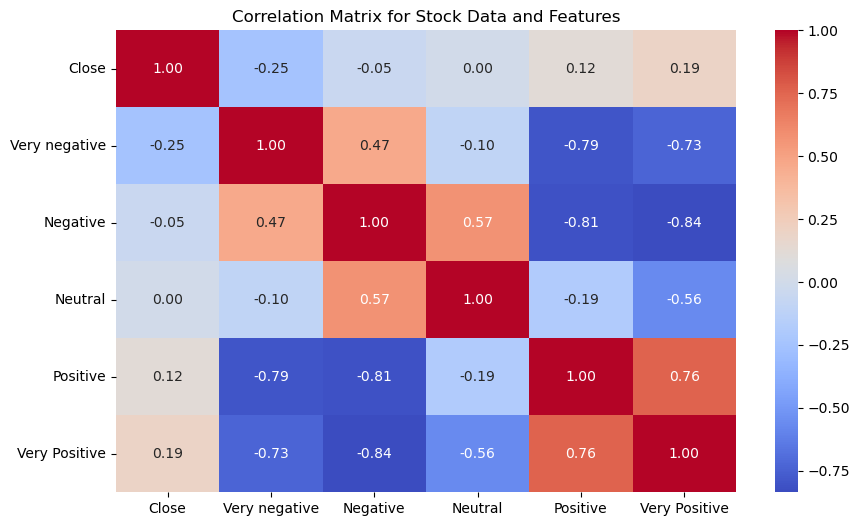

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data (Assuming the dataset is already in a DataFrame 'df')
dfMerged['Date'] = pd.to_datetime(dfMerged['Date'])  # Ensure 'Date' is in datetime format

# 1. Check for missing values
print("Missing values:")
print(dfMerged.isnull().sum())

# 2. Statistical summary of numerical columns
print("Statistical summary:")
print(dfMerged.describe())


# 4. Time Series Analysis: Plot stock prices over time (e.g., 'Close' price)
plt.figure(figsize=(10, 6))
plt.plot(dfMerged['Date'], dfMerged['Close'])
plt.title('Stock Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

# 5. Correlation Matrix (Stock Features & Additional Features)
plt.figure(figsize=(10, 6))
correlation_matrix = dfMerged[['Close', 'Very negative', 'Negative', 'Neutral', 'Positive', 'Very Positive']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix for Stock Data and Features')
plt.show()

# 6. Handle Missing Values (if you choose to fill or drop)
df_cleaned = dfMerged.dropna(subset=['Very negative', 'Negative', 'Neutral', 'Positive', 'Very Positive'])  # Drop rows with NaNs in features
# Alternatively, you can fill NaN with a specific value or interpolation (e.g., df['feature1'].fillna(df['feature1'].mean(), inplace=True))



In [14]:
def createDataset(dataset, target, lookBack=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - lookBack):
        a = dataset[i:(i + lookBack), :]
        dataX.append(a)
        dataY.append(target[i + lookBack])
    return np.array(dataX), np.array(dataY)

features = dfMerged.drop(['Date', 'Close'], axis=1).values
target = dfMerged['Close'].values

scalerFeatures = MinMaxScaler(feature_range=(0, 1))
scalerTarget = MinMaxScaler(feature_range=(0, 1))

featuresScaled = scalerFeatures.fit_transform(features)
targetScaled = scalerTarget.fit_transform(target.reshape(-1, 1))

lookBack = 60
X, y = createDataset(featuresScaled, targetScaled, lookBack)
print(X[:2])
print(y[:2])

trainSize = int(len(X) * 0.8)
testSize = len(X) - trainSize
trainX, testX = X[0:trainSize, :], X[trainSize:len(X), :]
trainY, testY = y[0:trainSize], y[trainSize:len(y)]

trainX = np.reshape(trainX, (trainX.shape[0], lookBack, trainX.shape[2]))
testX = np.reshape(testX, (testX.shape[0], lookBack, testX.shape[2]))

print(testSize)

[[[0.17753979 0.16613977 0.19101115 ... 0.33877192 0.10374545 0.02633289]
  [0.22460246 0.18861955 0.2093097  ... 0.3406655  0.10624497 0.02603635]
  [0.26062961 0.21355819 0.23467089 ... 0.34255908 0.10874449 0.0257398 ]
  ...
  [0.38364165 0.35124691 0.40545741 ... 0.13294889 0.06081821 0.02833625]
  [0.39662449 0.34562697 0.39036921 ... 0.13059042 0.06097543 0.03091665]
  [0.37130796 0.32068847 0.37624393 ... 0.12823196 0.06113265 0.03349705]]

 [[0.22460246 0.18861955 0.2093097  ... 0.3406655  0.10624497 0.02603635]
  [0.26062961 0.21355819 0.23467089 ... 0.34255908 0.10874449 0.0257398 ]
  [0.24310293 0.19775205 0.23756014 ... 0.34445266 0.11124401 0.02544325]
  ...
  [0.39662449 0.34562697 0.39036921 ... 0.13059042 0.06097543 0.03091665]
  [0.37130796 0.32068847 0.37624393 ... 0.12823196 0.06113265 0.03349705]
  [0.40733524 0.3505444  0.3942215  ... 0.1258735  0.06128986 0.03607745]]]
[[0.37841352]
 [0.41482442]]
231


In [15]:
batchSize = 8
epoch = 88
neurons = 135
dropout = 0.15

model = Sequential()
model.add(LSTM(neurons, return_sequences=True, activation='tanh', input_shape=(lookBack, features.shape[1])))
model.add(Dropout(dropout))
model.add(LSTM(neurons, return_sequences=True, activation='tanh'))
model.add(Dropout(dropout))
model.add(LSTM(neurons, activation='tanh'))
model.add(Dropout(dropout))

model.add(Dense(units=1, activation='linear', activity_regularizer=regularizers.l1(0.00001)))
#model.add(Activation('tanh'))
model.summary()

model.compile(loss='mean_squared_error' , optimizer='RMSprop')

model.fit(trainX, trainY, epochs=epoch, batch_size=batchSize, verbose=1, validation_split=0.2)

C:\Users\will\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 135)        │        78,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 135)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 135)        │       146,340 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 135)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 135)            │       146,340 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 135)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           136 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 371,656 (1.42 MB)

 Trainable params: 371,656 (1.42 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/88
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - loss: 0.0492 - val_loss: 0.0033
Epoch 2/88
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.0101 - val_loss: 0.0017
Epoch 3/88
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.0092 - val_loss: 0.0036
Epoch 4/88
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.0073 - val_loss: 0.0022
Epoch 5/88
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.0055 - val_loss: 0.0034
Epoch 6/88
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.0049 - val_loss: 0.0075
Epoch 7/88
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.0056 - val_loss: 0.0037
Epoch 8/88
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 0.0041 - val_loss: 9.4860e-04
Epoch 9/88
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.0040 - val_loss: 0.0058
Epoch 10/88
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.0042 - val_loss: 0.0050
Epoch 11/88
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0041 - val_loss: 0.0012
Epoch 12/88
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss:

92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.0014 - val_loss: 6.1228e-04
Epoch 69/88
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.0013 - val_loss: 5.9497e-04
Epoch 70/88
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0015 - val_loss: 5.9498e-04
Epoch 71/88
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.0014 - val_loss: 6.0898e-04
Epoch 72/88
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0014 - val_loss: 5.8117e-04
Epoch 73/88
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.0016 - val_loss: 6.4762e-04
Epoch 74/88
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 75/88
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0014 - val_loss: 8.4342e-04
Epoch 76/88
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.0016 - val_loss: 7.7520e-04
Epoch 77/88
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.0013 - val_loss: 5.8833e-04
Epoch 78/88
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.0012 - val_loss: 6.1006e-04
Epoch 79/88
92/92 ━━━━━━━━

In [16]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredictInv = scalerTarget.inverse_transform(trainPredict)
trainYInv = scalerTarget.inverse_transform(np.reshape(trainY, (trainY.shape[0], 1)))
testPredictInv = scalerTarget.inverse_transform(testPredict)
testYInv = scalerTarget.inverse_transform(np.reshape(testY, (testY.shape[0], 1)))

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


In [17]:
trainY

array([[0.37841352],
       [0.41482442],
       [0.40312088],
       [0.47529258],
       [0.42587774],
       [0.4450585 ],
       [0.44668396],
       [0.44408324],
       [0.47561775],
       [0.48537065],
       [0.48276981],
       [0.46228863],
       [0.34037705],
       [0.38589075],
       [0.39499345],
       [0.4317295 ],
       [0.42165143],
       [0.41059824],
       [0.39401819],
       [0.38881664],
       [0.39889471],
       [0.37548764],
       [0.39076727],
       [0.4262029 ],
       [0.42100135],
       [0.43693106],
       [0.41807547],
       [0.40409626],
       [0.42977887],
       [0.40409626],
       [0.40994803],
       [0.43888169],
       [0.43758127],
       [0.41384916],
       [0.42457732],
       [0.42912879],
       [0.40897265],
       [0.44050715],
       [0.44765934],
       [0.4492848 ],
       [0.44538366],
       [0.46196358],
       [0.42912879],
       [0.4548114 ],
       [0.42522753],
       [0.43920673],
       [0.43042908],
       [0.451

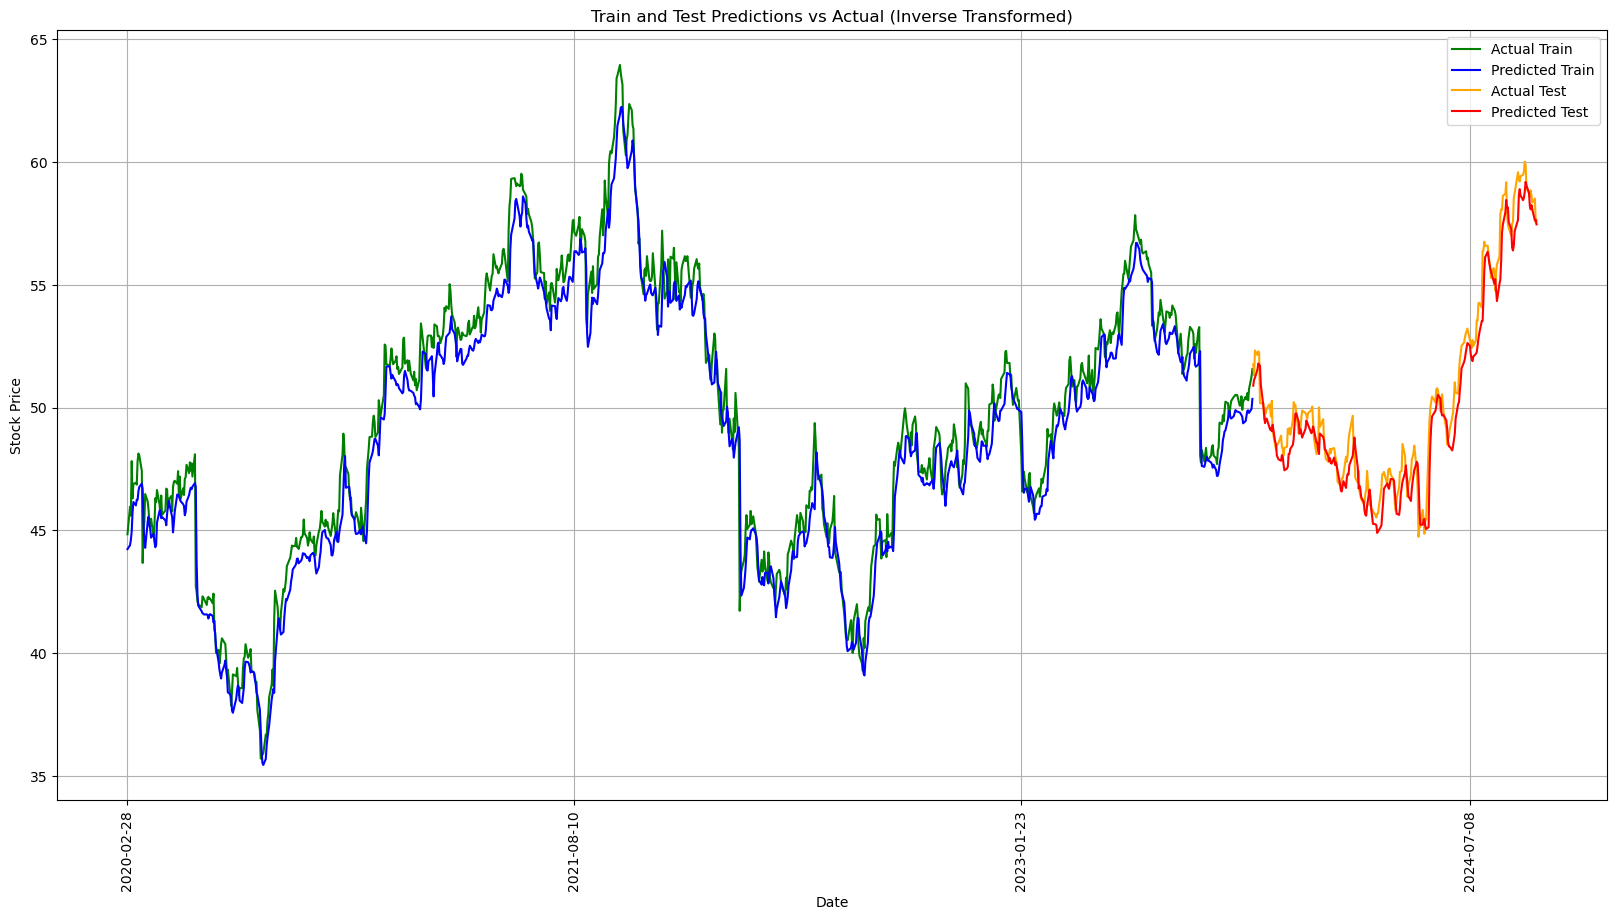

In [18]:
# Dates
dates = dfMerged['Date'].values
sampleInterval = 365  # Interval for sampled x-ticks
sampledDates = dates[::sampleInterval]

# Plot actual and predicted values
plt.figure(figsize=(20, 10))
plt.plot(dates[:len(trainYInv)], trainYInv, label='Actual Train', color='green')
plt.plot(dates[:len(trainPredictInv)], trainPredictInv, label='Predicted Train', color='blue')

plt.plot(dates[len(trainYInv):len(trainYInv) + len(testYInv)], testYInv, label='Actual Test', color='orange')
plt.plot(dates[len(trainYInv):len(trainYInv) + len(testPredictInv)], testPredictInv, label='Predicted Test', color='red')

# X-ticks
plt.xticks(sampledDates, rotation=90)

# Add labels and legend
plt.title('Train and Test Predictions vs Actual (Inverse Transformed)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid()
plt.show()

Shape of Test Residuals: (231,)
Test Residuals (first 10): [ 0.86862183  0.17336273  1.11919403  0.58757782  0.48931122  0.51249695
 -1.53494644 -0.7446785   0.09972763 -0.17475891]


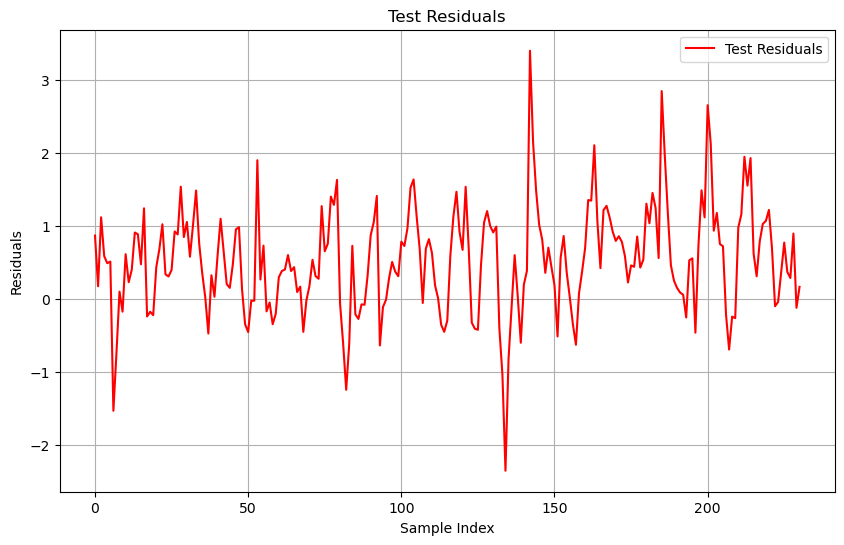

In [29]:
lstm_predictions = testPredictInv[:, 0]

testY = testYInv[:, 0] 

residuals = testY - lstm_predictions

print("Shape of Test Residuals:", residuals.shape)
print("Test Residuals (first 10):", residuals[:10])

plt.figure(figsize=(10, 6))
plt.plot(residuals, label='Test Residuals', color='red')
plt.title('Test Residuals')
plt.xlabel('Sample Index')
plt.ylabel('Residuals')
plt.legend()
plt.grid(True)
plt.show()


C:\Users\will\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


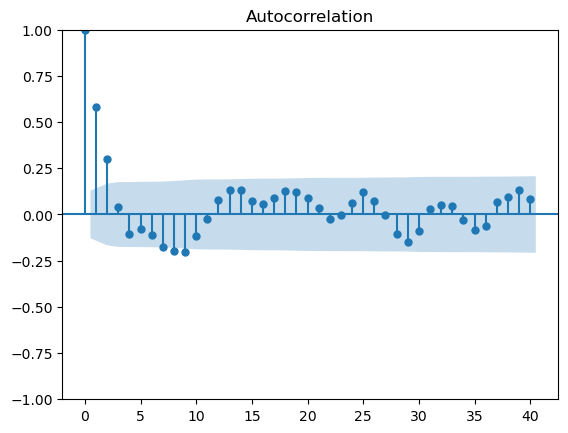

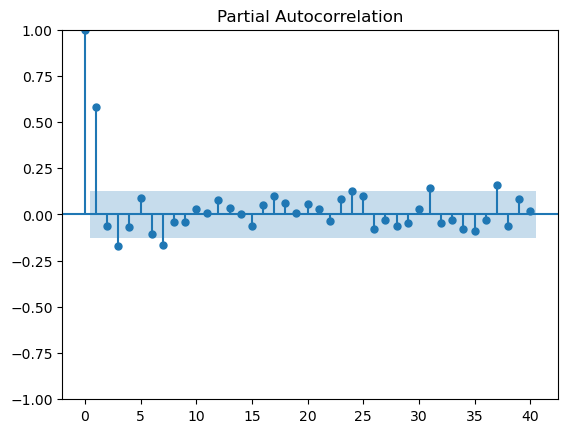

In [30]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Plot ACF and PACF to identify AR and MA orders
sm.graphics.tsa.plot_acf(residuals, lags=40)
sm.graphics.tsa.plot_pacf(residuals, lags=40)
plt.show()

In [31]:
import pmdarima as pm
import numpy as np
# Assuming residuals are univariate, ensure they are in 1D
residuals = residuals.reshape(-1)  # Flatten if necessary

# Fit auto_arima model to search over a very large range
auto_arima_model = pm.auto_arima(residuals, 
                                 p=range(0, 100),    # Search for p values from 0 to 100 (or more)
                                 d=None,             # Let auto_arima detect the order of differencing (d)
                                 q=range(0, 100),    # Search for q values from 0 to 100 (or more)
                                 seasonal=False,
                                 stepwise=True,     
                                 trace=True,         # Show output of model fitting process
                                 error_action='ignore',  # Ignore if an order does not fit
                                 suppress_warnings=True,  # Suppress warnings for cleaner output
                                 maxiter=30)     

# Summary of the chosen ARIMA model
print(auto_arima_model.summary())

# Forecast residuals for the length of the test set
arima_residual_predictions = auto_arima_model.predict(n_periods=len(testY))

# Check the predicted residuals
print(arima_residual_predictions.shape)
print(arima_residual_predictions[:5])


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=429.050, Time=0.29 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=607.290, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=438.369, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=502.468, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=439.567, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=441.793, Time=0.07 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=436.187, Time=0.21 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=423.618, Time=0.23 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=427.075, Time=0.20 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=432.035, Time=0.25 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=420.185, Time=0.25 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=419.746, Time=0.19 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=440.947, Time=0.07 sec
 ARIMA(1,0,5)(0,0,0)[0]             : AIC=421.233, Time=0.26 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=439.1

In [32]:
# Fit ARIMA model to the residuals
import statsmodels.api as sm
arima_model = sm.tsa.arima.ARIMA(residuals, order=(0,0,0))  # Adjust order as needed
arima_fitted = arima_model.fit()

# Predict residuals using ARIMA
arima_residual_predictions = arima_fitted.forecast(steps=len(testX))

In [33]:
hybrid_predictions = lstm_predictions + arima_residual_predictions


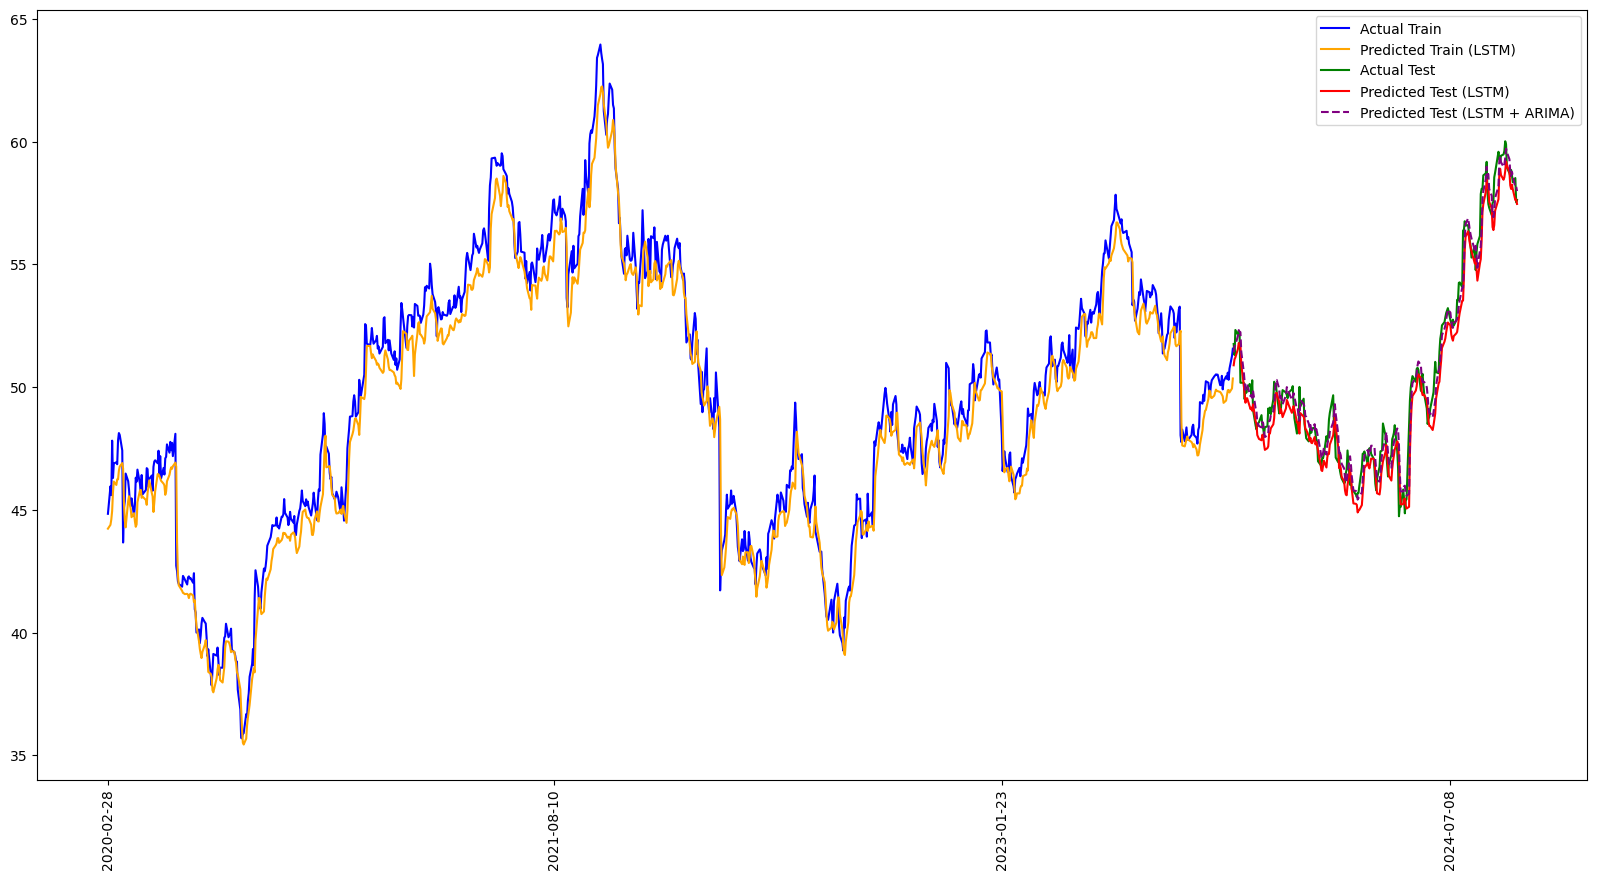

In [34]:

# Extract the dates (already available in your dataframe)
dates = dfMerged['Date'].values

# Sample interval for x-axis
sampleInterval = 365
sampledDates = dates[::sampleInterval]

# Create the plot
plt.figure(figsize=(20, 10))

# Plot actual training values
plt.plot(dates[:len(trainY)], trainYInv, label='Actual Train', color='blue')

# Plot predicted training values (LSTM only)
plt.plot(dates[:len(trainPredictInv)], trainPredictInv, label='Predicted Train (LSTM)', color='orange')

# Plot actual test values
plt.plot(dates[len(trainY):len(trainY) + len(testY)], testYInv, label='Actual Test', color='green')

# Plot predicted test values (LSTM only)
plt.plot(dates[len(trainPredictInv):len(trainPredictInv) + len(testPredictInv)], testPredictInv, label='Predicted Test (LSTM)', color='red')

# Plot predicted test values (LSTM-ARIMA hybrid)
plt.plot(dates[len(trainPredictInv):len(trainPredictInv) + len(hybrid_predictions)], 
         hybrid_predictions, label='Predicted Test (LSTM + ARIMA)', color='purple', linestyle='--')

# Set xticks for the sampled dates
plt.xticks(sampledDates, rotation=90)

# Add legend
plt.legend()

# Show the plot
plt.show()


In [35]:




# Generate hybrid model predictions for training data
hybrid_train_predictions = lstm_predictions

# Calculate metrics for LSTM-only model
mse_lstm = mean_squared_error(testYInv, testPredictInv)
rmse_lstm = np.sqrt(mse_lstm)
mae_lstm = mean_absolute_error(testYInv, testPredictInv)
r2_lstm = r2_score(testYInv, testPredictInv)
mape_lstm = mean_absolute_percentage_error(testYInv, testPredictInv)

# Calculate metrics for LSTM-ARIMA hybrid model
mse_hybrid = mean_squared_error(testYInv, hybrid_predictions)
rmse_hybrid = np.sqrt(mse_hybrid)
mae_hybrid = mean_absolute_error(testYInv, hybrid_predictions)
r2_hybrid = r2_score(testYInv, hybrid_predictions)
mape_hybrid = mean_absolute_percentage_error(testYInv, hybrid_predictions)

# Print the results for LSTM-only model
print(f"LSTM-Only Model Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse_lstm:.5f}")
print(f"Root Mean Squared Error (RMSE): {rmse_lstm:.5f}")
print(f"Mean Absolute Error (MAE): {mae_lstm:.5f}")
print(f"R-squared (R²): {r2_lstm:.5f}")
print(f"Testing Accuracy: {100 - (rmse_lstm / np.mean(testYInv) * 100):.2f}%\n")

# Print the results for LSTM-ARIMA hybrid model
print(f"LSTM-ARIMA Hybrid Model Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse_hybrid:.5f}")
print(f"Root Mean Squared Error (RMSE): {rmse_hybrid:.5f}")
print(f"Mean Absolute Error (MAE): {mae_hybrid:.5f}")
print(f"R-squared (R²): {r2_hybrid:.5f}")
print(f"Testing Accuracy: {100 - (rmse_hybrid / np.mean(testYInv) * 100):.2f}%")


LSTM-Only Model Evaluation Metrics:
Mean Squared Error (MSE): 0.80447
Root Mean Squared Error (RMSE): 0.89692
Mean Absolute Error (MAE): 0.70740
R-squared (R²): 0.95179
Testing Accuracy: 98.23%

LSTM-ARIMA Hybrid Model Evaluation Metrics:
Mean Squared Error (MSE): 0.52953
Root Mean Squared Error (RMSE): 0.72769
Mean Absolute Error (MAE): 0.55281
R-squared (R²): 0.96827
Testing Accuracy: 98.56%


In [36]:


# Ensure the index of stock_data is converted to datetime if not already done
stock_data.index = pd.to_datetime(stock_data.index)

# Reset the index of stock_data to turn 'Date' into a regular column
stock_data = stock_data.reset_index()

# Create a custom business day offset that excludes weekends and US federal holidays
us_business_day = CustomBusinessDay(calendar=USFederalHolidayCalendar())                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

# Assume start_date is the first date in the test set
start_date = stock_data['Date'].iloc[-testSize]  # Assuming `stock_data` contains the full dataset with a 'Date' column

# Generate predicted dates excluding weekends and US federal holidays
predicted_dates = pd.date_range(start=start_date, periods=len(hybrid_predictions), freq=us_business_day)

# Create a DataFrame to save predictions
predictions_df = pd.DataFrame({
    'Date': predicted_dates,
    'Predicted': hybrid_predictions
})

# Save predictions to the 'predictions' directory
predictions_file_path = f"predictions/{stock_name}_hybrid_predictions.csv"
predictions_df.to_csv(predictions_file_path, index=False)

print(f"Predictions saved to '{predictions_file_path}'")


Predictions saved to 'predictions/CSCO_hybrid_predictions.csv'


In [37]:
# Create a dictionary with the results
results_dict = {

    "LSTM-ARIMA Hybrid Model": {
        "MSE": mse_hybrid,
        "RMSE": rmse_hybrid,
        "MAE": mae_hybrid,
        "R-squared (R²)": r2_hybrid,
        "Testing Accuracy (%)": 100 - (rmse_hybrid / np.mean(testYInv) * 100)
    }
}

# Generate the file name based on the stock name
file_name = f"model_evaluation/{stock_name}_model_evaluation.json"

# Save the results as a JSON file with the dynamic name
with open(file_name, "w") as f:
    json.dump(results_dict, f, indent=4)

print(f"Results saved as {file_name}")

Results saved as model_evaluation/CSCO_model_evaluation.json


In [28]:
import optuna
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import RMSprop

# Function to build the LSTM model
def create_model(neurons, dropout):
    model = Sequential()
    model.add(LSTM(neurons, return_sequences=True, activation='tanh', input_shape=(lookBack, features.shape[1])))
    model.add(Dropout(dropout))
    model.add(LSTM(neurons, return_sequences=True, activation='tanh'))
    model.add(Dropout(dropout))
    model.add(LSTM(neurons, activation='tanh'))
    model.add(Dropout(dropout))
    model.add(Dense(units=1, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer=RMSprop())
    return model

# Objective function for optimization
def objective(trial):
    # Suggest hyperparameters
    neurons = trial.suggest_int('neurons', 50, 150)          # Range for neurons
    dropout = trial.suggest_uniform('dropout', 0.1, 0.5)     # Range for dropout
    batch_size = trial.suggest_int('batch_size', 8, 64)      # Range for batch size
    epochs = trial.suggest_int('epochs', 20, 100)            # Range for epochs

    # Create and train the model
    model = create_model(neurons, dropout)
    history = model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0)
    
    # Return validation loss as the metric to minimize
    val_loss = min(history.history['val_loss'])
    return val_loss

# Create study and optimize
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Best parameters found
best_params = study.best_params
print("Best parameters: ", best_params)


[I 2025-01-02 19:10:01,368] A new study created in memory with name: no-name-24643aca-db2c-42f7-b3e0-3eccb58dcfc9
C:\Users\will\AppData\Local\Temp\ipykernel_67656\202567461.py:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.1, 0.5)     # Range for dropout
C:\Users\will\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-01-02 19:12:29,793] Trial 0 finished with value: 0.0009192154975607991 and parameters: {'neurons': 146, 'dropout': 0.17727503644922865, 'batch_size': 62, 'epochs': 63}. Best is trial 0 with value: 0.0009192154975607991.
[I 2025-01-02 19:15:13,529] Trial 1 fi

[I 2025-01-02 21:24:04,950] Trial 33 finished with value: 0.0006117247976362705 and parameters: {'neurons': 108, 'dropout': 0.22028768483165914, 'batch_size': 13, 'epochs': 94}. Best is trial 12 with value: 0.0005281267804093659.
[I 2025-01-02 21:29:58,206] Trial 34 finished with value: 0.0005851520108990371 and parameters: {'neurons': 115, 'dropout': 0.24934151015419356, 'batch_size': 11, 'epochs': 80}. Best is trial 12 with value: 0.0005281267804093659.
[I 2025-01-02 21:35:31,030] Trial 35 finished with value: 0.0006393454968929291 and parameters: {'neurons': 126, 'dropout': 0.285770202441146, 'batch_size': 17, 'epochs': 94}. Best is trial 12 with value: 0.0005281267804093659.
[I 2025-01-02 21:37:51,166] Trial 36 finished with value: 0.0009197807521559298 and parameters: {'neurons': 135, 'dropout': 0.194170997607714, 'batch_size': 64, 'epochs': 70}. Best is trial 12 with value: 0.0005281267804093659.
[I 2025-01-02 21:43:38,639] Trial 37 finished with value: 0.0005794285680167377 and 

[W 2025-01-02 23:50:00,614] Trial 62 failed with value None.


KeyboardInterrupt: 